# Keras: Tabular Forecasting

*Climate Forecasting Using a 2D Time Series of Multi-Variate Features Over Shifting Windows.*

![delhi](../images/india_weather.png)

Highly dimensional forecasting is another holy grail of deep learning. This process encodes information about the state of the future as a function of the states of the past. Here the learnable parameters of a neural network effectively serve as coefficients in an 'infinitely' long polynomial equation for predicting the future.

Most tutorials in this space focus on the stock market. To be fair, the NYSE provides a reliable source of uniform, time-stamped data. However, in this example we'll examine the climate of Delhi in order to predict both it's temperature and humidity in the future.

To do this, we'll use a sliding `aiqc.Window` wherein the past 25 days of data is used to predict the next 5 days of data. We'll study each 25 day interval (e.g. [0...24]) in the dataset and shift it forward by 5 days (e.g. [5...29]) to learn about the transformation it undergoes.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape
from keras.callbacks import History

from sklearn.preprocessing import RobustScaler, StandardScaler

import aiqc

---

## Example Data

Reference [Example Datasets](example_datasets.ipynb) for more information.

In [6]:
from aiqc import datum
import matplotlib.pyplot as plt

In [7]:
df = datum.to_pandas('delhi_climate.parquet')

In [8]:
df.head()

,day_of_year,temperature,humidity,wind,pressure
0,1,10.000000,84.500000,0.000000,1015.666667
1,2,7.400000,92.000000,2.980000,1017.800000
2,3,7.166667,87.000000,4.633333,1018.666667
3,4,8.666667,71.333333,1.233333,1017.166667
4,5,6.000000,86.833333,3.700000,1016.500000


<AxesSubplot:title={'center':'Temperature'}>

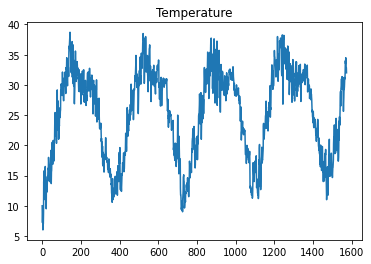

In [9]:
df['temperature'].plot(title='Temperature')

<AxesSubplot:title={'center':'Humidity'}>

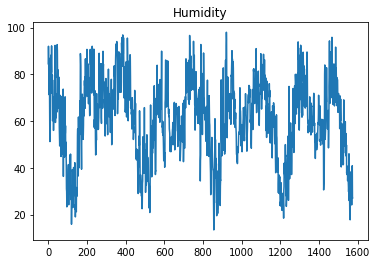

In [10]:
df['humidity'].plot(title='Humidity')

---

## a) High-Level API

In [84]:
from sklearn.preprocessing import StandardScaler

In [88]:
splitset = aiqc.Pipeline.Tabular.make(    
    dataFrame_or_filePath = df
    , label_column = None
    , features_excluded = ['pressure','wind']
    , feature_encoders = [{
        "sklearn_preprocess": StandardScaler()
        , "dtypes": ['float64', 'int64']
    }]
    , size_test = 0.12
    , size_validation = 0.18
    , size_window = 25
    , size_shift = 5
)


___/ featurecoder_index: 0 \_________


=> Info - System overriding user input to set `sklearn_preprocess.copy=False`.
   This saves memory when concatenating the output of many encoders.

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.

['temperature', 'humidity', 'day_of_year']

=> Done. All feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



In [89]:
def fn_build(features_shape, label_shape, **hp):
    model = Sequential()
    if hp['LSTM_2']:
        model.add(LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=True
        ))
        model.add(LSTM(
            hp['neuron_count']
            , activation=hp['activation']
            , return_sequences=False
        ))
    else:
        model.add(LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=False
        ))
    # Automatically flattens.
    model.add(Dense(label_shape[0]*label_shape[1]*hp['dense_multiplier'], activation=hp['activation']))
    model.add(Dropout(0.3))
    model.add(Dense(label_shape[0]*label_shape[1], activation=hp['activation'])) ### is this right shape?
    model.add(Dropout(0.3))
    # Reshape to be 3D.
    model.add(Reshape((label_shape[0], label_shape[1])))
    
    return model

In [90]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss=loser
        , optimizer=optimizer
        , metrics=['mean_squared_error']
    )
        
    model.fit(
        samples_train['features'], samples_train['features']
        , validation_data = (samples_evaluate['features'], samples_evaluate['features'])
        , verbose = 0
        , batch_size = hp['batch_size']
        , epochs = hp['epochs']
        , callbacks = [History()]
    )
    return model

In [91]:
hyperparameters = {
    "LSTM_2": [False]
    , "activation": ['tanh']
    , "neuron_count": [6]
    , "batch_size": [6]
    , "epochs": [150]
    , "dense_multiplier": [1]
}

In [92]:
queue = aiqc.Experiment.make(
    library = "keras"
    , analysis_type = "regression"
    , fn_build = fn_build
    , fn_train = fn_train
    , splitset_id = splitset.id
    , repeat_count = 2
    , hide_test = False
    , hyperparameters = hyperparameters
)

In [93]:
queue.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 2/2 [01:16<00:00, 38.38s/it]


---

## b) Low-Level API

Reference [Low-Level API Docs](api_low_level.ipynb) for more information including how to work with non-tabular data and defining optimizers.

In [18]:
dataset = aiqc.Dataset.Tabular.from_pandas(df)

In [19]:
feature = dataset.make_feature(exclude_columns=['pressure','wind'])

In [20]:
window = feature.make_window(size_window=25, size_shift=5)

In [21]:
encoderset = feature.make_encoderset()

In [83]:
from sklearn.preprocessing import StandardScaler

In [23]:
encoderset.make_featurecoder(
    sklearn_preprocess = StandardScaler()
    , dtypes = ['float64', 'int64']
)


___/ featurecoder_index: 0 \_________


=> Info - System overriding user input to set `sklearn_preprocess.copy=False`.
   This saves memory when concatenating the output of many encoders.

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.

['temperature', 'humidity', 'day_of_year']

=> Done. All feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



<Featurecoder: 1>

Here we `unsupervised_stratify_col` in order to ensure that each split uses different seasons of the year.

In [24]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature.id]
    , label_id = None
    , size_test = 0.12
    , size_validation = 0.18
    , bin_count = 26
    , unsupervised_stratify_col = 'day_of_year'
)

In [25]:
def fn_build(features_shape, label_shape, **hp):
    model = Sequential()
    if hp['LSTM_2']:
        model.add(LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=True
        ))
        model.add(LSTM(
            hp['neuron_count']
            , activation=hp['activation']
            , return_sequences=False
        ))
    else:
        model.add(LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=False
        ))
    # Automatically flattens.
    model.add(Dense(label_shape[0]*label_shape[1]*hp['dense_multiplier'], activation=hp['activation']))
    model.add(Dropout(0.3))
    model.add(Dense(label_shape[0]*label_shape[1], activation=hp['activation'])) ### is this right shape?
    model.add(Dropout(0.3))
    # Reshape to be 3D.
    model.add(Reshape((label_shape[0], label_shape[1])))
    
    return model

In [26]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss=loser
        , optimizer=optimizer
        , metrics=['mean_squared_error']
    )
        
    model.fit(
        samples_train['features'], samples_train['features']
        , validation_data = (samples_evaluate['features'], samples_evaluate['features'])
        , verbose = 0
        , batch_size = hp['batch_size']
        , epochs = hp['epochs']
        , callbacks = [History()]
    )
    return model

In [27]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "regression"
    , fn_build = fn_build
    , fn_train = fn_train
)

In [28]:
hyperparameters = {
    "LSTM_2": [False]
    , "activation": ['tanh']
    , "neuron_count": [6]
    , "batch_size": [6]
    , "epochs": [150]
    , "dense_multiplier": [1]
}

In [29]:
hyperparamset = algorithm.make_hyperparamset(
    hyperparameters = hyperparameters
)

In [30]:
queue = algorithm.make_queue(
    splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , repeat_count = 2
)

In [31]:
queue.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 2/2 [01:11<00:00, 35.59s/it]


For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.

---

## Inference

In [79]:
queue.metrics_to_pandas()

,hyperparamcombo_id,job_id,repeat_index,predictor_id,split,explained_variance,loss,mse,r2
3,1,1,1,2,test,0.747744,0.398760,0.268788,0.739807
4,1,1,1,2,validation,0.732404,0.409312,0.284035,0.725454
5,1,1,1,2,train,0.731287,0.410404,0.290169,0.723696
6,1,1,1,2,2,0.221851,0.359187,0.263513,-0.321117
7,1,1,1,2,3,0.571577,0.281987,0.115679,-2.995878
0,1,1,0,1,test,0.744197,0.398550,0.270387,0.736685
1,1,1,0,1,validation,0.721453,0.413770,0.291870,0.715159
2,1,1,0,1,train,0.724153,0.412656,0.295115,0.717280


In [34]:
predictor = aiqc.Predictor.get_by_id(2)

Let's fetch an arbitrary 30 (25+5) days worth of data.

In [58]:
infer_df = df[430:460].reset_index(drop=True)

In [59]:
infer_df.shape

(30, 5)

In [60]:
infer_dataset = aiqc.Dataset.Tabular.from_pandas(infer_df)

In [61]:
infer_feature = infer_dataset.make_feature(exclude_columns=['pressure','wind'])

In [62]:
infer_window = infer_feature.make_window(size_window=25, size_shift=5)

In [63]:
infer_splitset = aiqc.Splitset.make(
    feature_ids = [infer_feature.id]
    , size_test = None
)

In [64]:
import numpy as np

In [65]:
infer_prediction = predictor.infer(splitset_id=infer_splitset.id)

In [66]:
infer_predictions = infer_prediction.predictions[str(infer_splitset.id)]

Looking at the shape, we have 1 prediction with 25 days and 3 features worth of data.

In [67]:
infer_predictions.shape

(1, 25, 3)

Let's compare this to the original data. We'll grab the last 7 days of our real data.

In [69]:
real_data = infer_df[14:].drop(columns=['wind']).reset_index(drop=True)

In [94]:
real_data

,day_of_year,temperature,humidity,pressure
0,80,22.500000,64.750000,1007.125000
1,81,25.000000,59.500000,1007.000000
2,82,22.750000,61.875000,1010.625000
3,83,22.375000,73.125000,1011.625000
4,84,24.625000,60.250000,1010.500000
5,85,25.125000,58.875000,1010.625000
6,86,23.500000,63.250000,1011.750000
7,87,24.428571,67.571429,1011.142857
8,88,25.875000,55.625000,1011.250000
9,89,24.125000,46.750000,1009.875000


And the last 7 days of our forecasted data.

In [71]:
import pandas as pd

In [72]:
forecasted_data = infer_predictions[0][7:]

In [73]:
forecasted_data

array([[102.214226,  23.187437,  66.333115],
       [103.289185,  23.273087,  64.589355],
       [102.75758 ,  23.477032,  64.080315],
       [105.351326,  24.101501,  62.576088],
       [106.06416 ,  24.08014 ,  62.464577],
       [105.255516,  24.177141,  62.537296],
       [104.481735,  24.031649,  61.897343],
       [107.39741 ,  24.345854,  61.433167],
       [108.744125,  24.414034,  60.870914],
       [109.54942 ,  24.925653,  60.790737],
       [113.03691 ,  24.52396 ,  59.554276],
       [110.72479 ,  24.667864,  58.672844],
       [111.09558 ,  25.16237 ,  58.63266 ],
       [112.36801 ,  25.623455,  58.491837],
       [110.99765 ,  25.085756,  58.500893],
       [112.88907 ,  25.04775 ,  57.381844],
       [113.64207 ,  25.349289,  57.55841 ],
       [114.67511 ,  25.954702,  57.936382]], dtype=float32)

In [74]:
forecasted_data = pd.DataFrame(forecasted_data)

In [75]:
temperature_df = pd.concat([real_data[['temperature']], forecasted_data[[1]]], axis=1)

<AxesSubplot:title={'center':'Temperature'}>

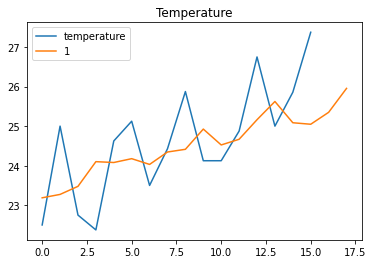

In [96]:
temperature_df.plot(title='Temperature')

In [77]:
humidity_df = pd.concat([real_data[['humidity']], forecasted_data[[2]]], axis=1)

<AxesSubplot:title={'center':'Humidity'}>

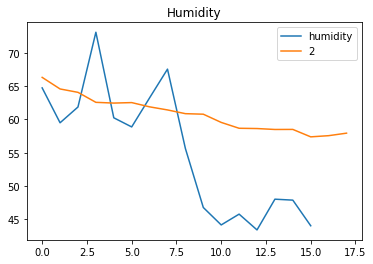

In [97]:
humidity_df.plot(title='Humidity')

We're not exactly ready to start our own weather channel, but there is definitely evidence of learning.